In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
#import graphviz
import numpy as np
import pandas as pd
import xgboost as xgb
import sys
import kaggle_xgb
import calc_ndcg
#from sklearn.grid_search import ParameterGrid

Read in just the testing and training data.

In [94]:
#train_subset = pd.read_csv('../data/train_users_2.csv', nrows = 100000, index_col='id')
#train_data = pd.read_csv('../data/train_users_2.csv', index_col = 'id')
test_data = pd.read_csv('../data/test_users.csv', index_col = 'id')
sessions = pd.read_csv('../data/sessions.csv')
#age = pd.read_csv('../data/age_gender_bkts.csv')
#countries = pd.read_csv('../data/countries.csv')

all_df is a pickled obect where the training and test has already been concatenated onall columns except 'country_destination'

In [102]:
test_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
5555280,5uwns89zht,show,view,user_profile,-unknown-,79
5555281,5uwns89zht,search,click,view_search_results,-unknown-,17962
5555282,5uwns89zht,search,click,view_search_results,-unknown-,64883
5555283,5uwns89zht,show,view,p3,-unknown-,31180
5555284,5uwns89zht,authenticate,submit,login,iPhone,NaN


In [45]:
sessions = sessions[sessions.user_id.isin(train_data.index)]
test_sessions = sessions[sessions.user_id.isin(test_data.index)]

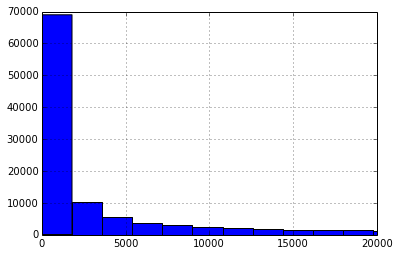

In [81]:
axes = plt.gca()
axes.set_xlim([0,20000])
#s.hist(ax=axes, bins= 1000)
tr_sessions[tr_sessions.action == 'this_hosting_reviews']['secs_elapsed'].hist(bins = 1000)

In [40]:
for x in actions.unique():
    if 'host' in x:
        print x

other_hosting_reviews_first
hosting_social_proof
other_hosting_reviews
this_hosting_reviews
host_2013
host_summary
why_host
new_host
locale_from_host
message_to_host_focus
message_to_host_change
host_cancel
this_hosting_reviews_3000


In [89]:
tr_sessions[tr_sessions.action == 'add_guests'].country_destination.value_counts(normalize = True)

US       38
ES        8
other     5
GB        2
FR        2
CA        1
Name: country_destination, dtype: int64

In [129]:
actions_both30 = set(tr_sessions.action.unique()) & set(actions_30.action.unique())

In [128]:
actions_30 = test_sessions.groupby('action').filter(lambda x: x['user_id'].nunique()>30)

In [182]:
tr_sessions[tr_sessions.action == 'ajax_google_translate'].country_destination.value_counts(normalize = True)

NDF      0.473958
other    0.177083
US       0.177083
IT       0.062500
ES       0.052083
FR       0.046875
DE       0.010417
Name: country_destination, dtype: float64

In [183]:
tr_sessions[tr_sessions.action == 'guest_booked_elsewhere'].country_destination.value_counts()

US       123
other     11
IT        10
DE         8
FR         3
NL         1
AU         1
Name: country_destination, dtype: int64

In [131]:
tr_sessions[tr_sessions.action == 'travel_plans_current'].country_destination.value_counts()

US       10071
NDF       5494
other     1680
FR         764
IT         599
GB         376
ES         373
CA         267
NL         136
DE         122
AU          50
PT          43
Name: country_destination, dtype: int64

In [122]:
tr_sessions[tr_sessions.action == 'place_worth'].country_destination.value_counts()

NDF      62
US        7
other     2
Name: country_destination, dtype: int64

In [141]:
tr_sessions[tr_sessions.action == 'payout_update'].country_destination.value_counts()

NDF      223
US        62
other     10
CA         3
FR         3
GB         2
Name: country_destination, dtype: int64

In [147]:
tr_sessions[tr_sessions.action == 'guest_billing_receipt'].country_destination.value_counts()

other    2
US       1
Name: country_destination, dtype: int64

In [213]:
tr_sessions[tr_sessions.action == 'guest_booked_elsewhere']

,user_id,action,action_type,action_detail,device_type,secs_elapsed,country_destination
q7e6kef9u2,q7e6kef9u2,guest_booked_elsewhere,message_post,message_post,Mac Desktop,129080,US
5lufs1wqyp,5lufs1wqyp,guest_booked_elsewhere,message_post,message_post,iPad Tablet,27787,US
5lufs1wqyp,5lufs1wqyp,guest_booked_elsewhere,message_post,message_post,iPad Tablet,0,US
5lufs1wqyp,5lufs1wqyp,guest_booked_elsewhere,message_post,message_post,iPad Tablet,1000,US
5lufs1wqyp,5lufs1wqyp,guest_booked_elsewhere,message_post,message_post,iPad Tablet,0,US
5lufs1wqyp,5lufs1wqyp,guest_booked_elsewhere,message_post,message_post,iPad Tablet,1000,US
5lufs1wqyp,5lufs1wqyp,guest_booked_elsewhere,message_post,message_post,iPad Tablet,0,US
5lufs1wqyp,5lufs1wqyp,guest_booked_elsewhere,message_post,message_post,iPad Tablet,0,US
c58mt0ubnv,c58mt0ubnv,guest_booked_elsewhere,message_post,message_post,Windows Desktop,166731,IT
eyy14cpfo4,eyy14cpfo4,guest_booked_elsewhere,message_post,message_post,Windows Desktop,55576,US


In [149]:
tr_sessions[tr_sessions.action == 'guest_booked_elsewhere'].country_destination.value_counts()

US       123
other     11
IT        10
DE         8
FR         3
NL         1
AU         1
Name: country_destination, dtype: int64

In [154]:
tr_sessions[tr_sessions.action == 'transaction_history'].country_destination.value_counts()

NDF      416
US       283
other     51
IT        20
GB        16
ES        14
FR        11
DE        10
CA         6
PT         3
Name: country_destination, dtype: int64

In [155]:
tr_sessions[tr_sessions.action == 'receipt'].country_destination.value_counts()

US       132
other     20
GB        13
ES        10
IT         7
FR         4
NL         3
PT         2
NDF        1
Name: country_destination, dtype: int64

In [161]:
tr_sessions[tr_sessions.action == 'countries_option'].country_destination.value_counts()

Series([], Name: country_destination, dtype: int64)

In [162]:
tr_sessions[tr_sessions.action == 'itinerary'].country_destination.value_counts()

US       599
NDF      119
other     81
ES        35
FR        27
IT        20
NL        17
GB        14
CA         4
AU         3
DE         2
PT         1
Name: country_destination, dtype: int64

In [185]:
tr_sessions[tr_sessions.action == 'travel_plans_previous'].country_destination.value_counts()

NDF      120
US        60
other     10
FR         5
GB         3
IT         2
NL         1
Name: country_destination, dtype: int64

In [177]:
tr_sessions[tr_sessions.action == 'cancel'].country_destination.value_counts()

US       143
NDF      105
other     21
IT        10
FR         6
ES         3
GB         2
DE         1
CA         1
NL         1
Name: country_destination, dtype: int64

In [178]:
tr_sessions[tr_sessions.action == 'office_location'].country_destination.value_counts()

NDF      57
other    14
GB        4
US        3
Name: country_destination, dtype: int64

In [184]:
tr_sessions[tr_sessions.action_detail == 'your_trips'].country_destination.value_counts()

US       10071
NDF       5494
other     1680
FR         764
IT         599
GB         376
ES         373
CA         267
NL         136
DE         122
AU          50
PT          43
Name: country_destination, dtype: int64

In [ ]:
secs_elapsed

In [216]:
tr_sessions[tr_sessions.user_id.isin(users)]

,user_id,action,action_type,action_detail,device_type,secs_elapsed,country_destination
aophlnjulu,aophlnjulu,index,-unknown-,-unknown-,iPhone,5013,NDF
aophlnjulu,aophlnjulu,active,-unknown-,-unknown-,iPhone,539,NDF
aophlnjulu,aophlnjulu,index,-unknown-,-unknown-,iPhone,4392,NDF
aophlnjulu,aophlnjulu,show,-unknown-,-unknown-,iPhone,61,NDF
aophlnjulu,aophlnjulu,show,-unknown-,-unknown-,iPhone,591,NDF
aophlnjulu,aophlnjulu,index,-unknown-,-unknown-,iPhone,4959,NDF
aophlnjulu,aophlnjulu,index,-unknown-,-unknown-,iPhone,4968,NDF
aophlnjulu,aophlnjulu,index,-unknown-,-unknown-,iPhone,2810,NDF
aophlnjulu,aophlnjulu,show,-unknown-,-unknown-,iPhone,2675,NDF
aophlnjulu,aophlnjulu,index,-unknown-,-unknown-,iPhone,429,NDF


In [214]:
users = tr_sessions[tr_sessions.action == 'host_summary'].user_id

In [196]:
tr_sessions[tr_sessions.action == 'phone_number_widget'].country_destination.value_counts()

US       1743
NDF      1720
other     256
FR        102
IT         69
GB         54
ES         52
CA         42
DE         33
NL         16
AU         13
PT          3
Name: country_destination, dtype: int64

In [187]:
tr_sessions[tr_sessions.action == 'payment_instruments'].country_destination.value_counts()

NDF      6348
US       3123
other     426
IT        103
FR         92
ES         72
GB         72
NL         35
CA         31
AU          6
PT          6
DE          6
Name: country_destination, dtype: int64

In [207]:
tr_sessions[tr_sessions.action == 'agree_terms_uncheck'].country_destination.value_counts(normalize = True)

US       0.451613
NDF      0.322581
other    0.064516
GB       0.053763
ES       0.032258
FR       0.032258
IT       0.010753
DE       0.010753
CA       0.010753
NL       0.010753
Name: country_destination, dtype: float64

In [199]:
test_sessions[test_sessions.action == 'print_confirmation']

,user_id,action,action_type,action_detail,device_type,secs_elapsed
6905690,8dut3dujgl,print_confirmation,-unknown-,-unknown-,Mac Desktop,2770
6905741,8dut3dujgl,print_confirmation,-unknown-,-unknown-,Mac Desktop,7460
6916428,9l1t9c8e1k,print_confirmation,-unknown-,-unknown-,Windows Desktop,6758
6943733,h8vr9btqnb,print_confirmation,-unknown-,-unknown-,Windows Desktop,3255
7052183,54kde8fbol,print_confirmation,-unknown-,-unknown-,Windows Desktop,6454
7085757,a1uqku5j1k,print_confirmation,-unknown-,-unknown-,iPad Tablet,15905
7152667,gkhvaal6nm,print_confirmation,-unknown-,-unknown-,Mac Desktop,3645
7152683,gkhvaal6nm,print_confirmation,-unknown-,-unknown-,Mac Desktop,3976
7169414,j3g9sjppdu,print_confirmation,-unknown-,-unknown-,Windows Desktop,6798
7230762,nvv3jqx1rz,print_confirmation,-unknown-,-unknown-,Mac Desktop,1583


In [209]:
options = ['recommend', 'recommendations', 'references', 'referrer_status']
for i in options:
    print tr_sessions[tr_sessions.action == i].country_destination.value_counts()

NDF      227
US        31
other      3
FR         1
Name: country_destination, dtype: int64
NDF      6931
US       2090
other     334
FR        101
IT         51
CA         21
GB         21
AU         20
ES         12
DE          6
NL          4
Name: country_destination, dtype: int64
NDF      2778
US       2726
other     584
FR        145
IT        134
DE         85
ES         77
GB         74
CA         72
NL         26
AU         25
PT          7
Name: country_destination, dtype: int64
NDF      1297
US        449
other      81
IT         26
FR         21
ES         17
GB         15
CA         13
NL         10
PT          4
DE          4
Name: country_destination, dtype: int64


In [179]:
tr_sessions[tr_sessions.action == 'travel_plans_current'].country_destination.value_counts()

US       10071
NDF       5494
other     1680
FR         764
IT         599
GB         376
ES         373
CA         267
NL         136
DE         122
AU          50
PT          43
Name: country_destination, dtype: int64

In [ ]:
'pay',
 'payment_instruments',
 'payment_methods',
 'payout_update',
 'payout_update'

In [130]:
actions_both30

{'10',
 '11',
 '12',
 '15',
 'about_us',
 'account',
 'active',
 'add_note',
 'agree_terms_check',
 'agree_terms_uncheck',
 'airbnb_picks',
 'ajax_check_dates',
 'ajax_google_translate_description',
 'ajax_google_translate_reviews',
 'ajax_image_upload',
 'ajax_lwlb_contact',
 'ajax_payout_edit',
 'ajax_payout_options_by_country',
 'ajax_photo_widget_form_iframe',
 'ajax_refresh_subtotal',
 'ajax_statsd',
 'apply_code',
 'apply_coupon_click',
 'apply_coupon_click_success',
 'apply_coupon_error',
 'apply_coupon_error_type',
 'apply_reservation',
 'ask_question',
 'at_checkpoint',
 'authenticate',
 'authorize',
 'available',
 'become_user',
 'calendar_tab_inner2',
 'callback',
 'campaigns',
 'cancel',
 'cancellation_policies',
 'cancellation_policy_click',
 'change',
 'change_currency',
 'change_password',
 'check',
 'clear_reservation',
 'click',
 'clickthrough',
 'collections',
 'complete',
 'complete_redirect',
 'complete_status',
 'confirm_email',
 'connect',
 'contact_new',
 'countr

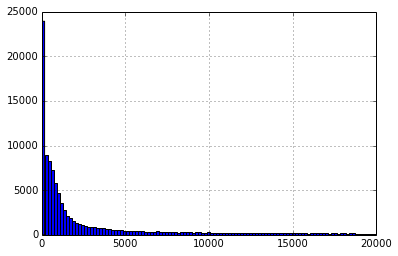

In [17]:
axes = plt.gca()
axes.set_xlim([0,20000])
s.hist(ax=axes, bins= 10000)

In [225]:
s2 = tr_sessions.groupby('user_id').filter(lambda x: len(x['action'])>3)

In [231]:
a = [1, 2, 3, 4]
a[-1:-3]

[]

In [233]:
s2.groupby('user_id').apply(lambda x: x.iloc[1:2, :] )

,,user_id,action,action_type,action_detail,device_type,secs_elapsed,country_destination
user_id,,,,,,,,
00023iyk9l,00023iyk9l,00023iyk9l,dashboard,view,dashboard,Mac Desktop,787,US
001wyh0pz8,001wyh0pz8,001wyh0pz8,search,click,view_search_results,Android App Unknown Phone/Tablet,1813,NDF
0028jgx1x1,0028jgx1x1,0028jgx1x1,reviews,data,listing_reviews,-unknown-,75,NDF
002qnbzfs5,002qnbzfs5,002qnbzfs5,payment_methods,-unknown-,-unknown-,iPhone,711,US
0035hobuyj,0035hobuyj,0035hobuyj,search_results,click,view_search_results,Mac Desktop,3196,US
00389675gq,00389675gq,00389675gq,edit,view,edit_profile,Windows Desktop,861,NDF
003iamz20l,003iamz20l,003iamz20l,search,click,view_search_results,iPad Tablet,29956,NDF
005jc3nbmb,005jc3nbmb,005jc3nbmb,ask_question,submit,contact_host,iPhone,816,NDF
006mls2sjw,006mls2sjw,006mls2sjw,similar_listings,data,similar_listings,Mac Desktop,861,ES


In [234]:
show                           752971
index                          253680
personalize                    237838
search_results                 226996
similar_listings               160553
ajax_refresh_subtotal          158712
update                         142247
search                         140240
social_connections              98137
lookup                          73930
reviews                         67638
active                          56039
header_userpic                  46638
create                          44893
collections                     41673
dashboard                       35476
track_page_view                 33123
campaigns                       26123
edit                            23671
unavailabilities                22673
s2[s2.country_destination != 'NDF'].action.value_counts(normalize = True)

show                                  2.210640e-01
personalize                           8.550750e-02
index                                 8.450716e-02
search_results                        7.777725e-02
ajax_refresh_subtotal                 6.339702e-02
similar_listings                      5.949819e-02
search                                2.687523e-02
update                                2.577881e-02
lookup                                2.514219e-02
social_connections                    1.906424e-02
dashboard                             1.554245e-02
create                                1.538986e-02
header_userpic                        1.460751e-02
reviews                               1.306380e-02
edit                                  1.305128e-02
track_page_view                       1.219708e-02
requested                             1.192903e-02
active                                1.118826e-02
qt2                                   1.046242e-02
calendar_tab_inner2            

In [235]:
s2[s2.country_destination == 'NDF'].action.value_counts()

show                           752971
index                          253680
personalize                    237838
search_results                 226996
similar_listings               160553
ajax_refresh_subtotal          158712
update                         142247
search                         140240
social_connections              98137
lookup                          73930
reviews                         67638
active                          56039
header_userpic                  46638
create                          44893
collections                     41673
dashboard                       35476
track_page_view                 33123
campaigns                       26123
edit                            23671
unavailabilities                22673
calendar_tab_inner2             19367
ajax_check_dates                18440
confirm_email                   16615
listings                        16569
notifications                   15964
other_hosting_reviews_first     15471
ask_question

In [5]:
s = sessions.groupby('user_id')['secs_elapsed'].apply(lambda x:  x.iloc[-1])

In [21]:
sessions.dropna(subset=['user_id'], inplace = True)

sessions_tr = sessions[sessions.user_id.isin(train_data.index)]
sessions_test = sessions[sessions.user_id.isin(test_data.index)]
a_ignore = set(sessions_tr.action.unique()) ^ set(sessions_test.action.unique())
#sessions.groupby('action')['action_detail']

#set(sessions_test.action_detail.unique()) ^ set(sessions_tr.action_detail.unique())
#sessions_test.action_detail.unique()
#sessions_tr.action_detail.unique()
#train_data['date_account_created'] = pd.to_datetime(train_data.date_account_created)
#x = train_data[train_data.date_account_created>='2014']
#train_data[train_data.index.isin(sessions_tr.user_id)].timestamp_first_active

In [ ]:
actions50 = [sessions_test.groupby('action')['user_id'].nunique() >50]
print 'Number of unique actions with more than 50 users:', np.sum(sessions_test.groupby('action')['user_id'].nunique()>50)

In [ ]:
#Let's get the actions with just one action type and one action detail.
print 'Number of unique actions with just one action type:',
np.sum(sessions.groupby('action')['action_detail'].nunique()==1)
#Take the intersection of these actions with a_ignore.

In [22]:
sessions['action_type'] = sessions['action_type'].fillna('missing')
sessions['action_detail'] = sessions['action_detail'].fillna('missing')

In [ ]:
#actions with null values
actions_null2 = sessions[pd.isnull(sessions.action_type)].action.unique()
actions_null == actions_null2

In [6]:
df = pd.DataFrame({'A': ['foo','bar','foo','foo', 'zoo','bar','foo','foo'],
                       'B': ['coo', np.NaN,'coo','coo', 'dude', np.NaN,'fooo','fooo']})

In [16]:
def test(x):
    print x.B.unqiue
    return x.B.nunique() == 1
df.groupby('A').filter(lambda x: test(x))

,A,B
4,zoo,dude


In [23]:
def custom_filter(x):
     return (x['action_detail'].nunique() == 1) and (x['action_type'].nunique() == 1) 
#get all actions with just one action_type and action 
actions_df = sessions.groupby('action').filter(lambda x: custom_filter(x))

In [24]:
#exclude those actions that are found in one table or the other
actions_df = actions_df[~actions_df.action.isin(a_ignore)]

In [32]:
actions_df.action[pd.isnull(actions_df['secs_elapsed'])].value_counts()

active                         11122
callback                        9029
impressions                     1112
header_userpic                   488
facebook_auto_login              344
dashboard                        135
at_checkpoint                     42
personalize                       37
set_user                          20
ask_question                      20
signup_login                      16
search_results                    12
manage_listing                    11
message_to_host_focus              7
edit_verification                  6
cancellation_policies              6
account                            4
ajax_refresh_subtotal              4
qt2                                3
top_destinations                   3
travel_plans_current               3
similar_listings                   3
payment_methods                    2
settings                           2
lookup                             2
ajax_lwlb_contact                  2
verify                             2
a

In [25]:
#info = actions_1.groupby(['user_id', 'action']).apply(lambda x: x['secs_elapsed'].sum())
action_cnts = actions_df.groupby(['user_id', 'action']).apply(lambda x: x['device_type'].count())

In [26]:
action_cnts = action_cnts.unstack(level=-1)

In [27]:
action_cnts.fillna(0, inplace=True)

In [28]:
pd.to_pickle(action_cnts, '../data/actions.p')

In [ ]:
#features with no time
#null_time, cnts = np.unique(actions_1[pd.isnull(actions_1['secs_elapsed'])].action, return_counts= True)
#zip(cnts, null_time)

In [ ]:
#find the number of users in test data with an action that is not found in the training sessions data
#We should look to find similar items to substitute them
for i in a_ignore:
    users = sessions_test[sessions_test.action == i].user_id.unique()
    if len(users) > 0:
        print i, len(users)

In [19]:
actions_df.action_type.unique()

array(['click', 'data', 'submit', '-unknown-', 'view', 'message_post',
       'partner_callback', 'booking_request', nan, 'booking_response'], dtype=object)

In [ ]:
#iterate through each action and find those that have more than one action detail/ action type
#s = sessions.groupby('action')['action_type'].nunique()
#sessions.groupby('action')['action_detail'].nunique()

In [ ]:
#convert targets to numerical values
targets = train_subset['country_destination']
targets_le = preprocessing.LabelEncoder()
targets = targets_le.fit_transform(targets)

In [ ]:
np.unique(targets)

In [ ]:
#pd.DataFrame(columns=['row_above', 'row_below', ])
results.sort_values(by= 'test-error-mean')

In [ ]:
def ndcg(preds, labels):
    """Calculate sum of normalzied discounted cumulative gain for the predictions
    The correct prediction will have a relevance of 1, incorrect predictions will have a relevance of 0.
    Weight the relevance values such that it is reduced logarithmically proportional to it its position     
    
    Args:
        preds: n*5 array of predictor targets
        labels: n*1 array targets
    Returns:
        sum of normalized discounted cumulative gain for all the predictions
    """
    
    #find positions where the prediction matches the label
    relv_pos = np.where(np.equal(preds, labels))[1]
    #weight func: log2(i+1), add one more to adjust for 0-based indexing
    total_ndcg = np.sum(1./np.log2(relv_pos+2))
    return total_ndcg
    
def evalerror(cls_prob, dtrain):
    """find top k predictions from probability matrix and call ndcg to find accuracy of predictions
    
    Args:
        cls_prob: 2D array, probability of each class for each person (n persons by m classes),
                  the column index corresponds with class
        labels: labels for the n persons
    returns:
        prediction accuracy using ndcg to evaluate predictions of each AirBNB user
    """
    #determine the top k predictions
    labels = dtrain.get_label()
    k = 5
    top_k = cls_prob.argsort(axis = 1)[:,:k:-1]
    #convert true values  and compared with predictions to check for equality
    labels = labels[:, None]
    return 'error', 1.-ndcg(top_k, labels)/len(labels)

In [ ]:
features = sorted(bst.get_fscore().items(), key = lambda x: x[1], reverse = True)
[(feat, all_df.columns[int(feat[1:])], score) for feat, score in features]